# Example ODE

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [17]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Threshold,PDEFIND
from deepymod_torch.training import train_split_full
from deepymod_torch.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod_torch.utils.types import TensorList
from deepymod_torch import Library

%load_ext autoreload
%autoreload 2
from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we prepare the dataset.

In [18]:
def dU_dt_sin(U, t):
    # Here U is a vector such that y=U[0] and z=U[1]. This function should return [y', z']
    return [U[1], -1*U[1] - 5*np.sin(U[0])]
U0 = [2.5, 0.4]
ts = np.linspace(0, 8, 500)
Y = odeint(dU_dt_sin, U0, ts)
T = ts.reshape(-1,1)

Here we can potentially rescale the Y and T axis and we plot the results

In [19]:
T_rs = T
Y_rs = Y/np.max(np.abs(Y),axis=0)

Let's plot it to get an idea of the data:

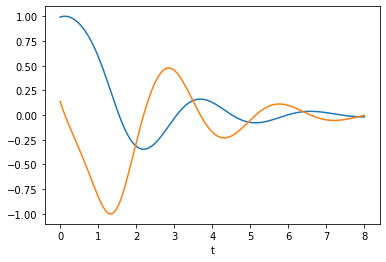

In [20]:
fig, ax = plt.subplots()
ax.plot(T_rs, Y_rs[:,0])
ax.plot(T_rs, Y_rs[:,1])
ax.set_xlabel('t')

plt.show()

In [21]:
number_of_samples = 400

idx = np.random.permutation(Y.shape[0])
X_train = torch.tensor(T_rs[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(Y_rs[idx, :][:number_of_samples], dtype=torch.float32)

In [22]:
print(X_train.shape, y_train.shape)

torch.Size([400, 1]) torch.Size([400, 2])


# Setup a custom library

In [23]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce

Here we show an example where we create a custom library. $\theta$ in this case containe $[1,u,v, sin(u),cos(u)]$ to showcase that non-linear terms can easily be added to the library

In [24]:
def library_non_linear_ODE(input, poly_order, diff_order):
    
    prediction, data = input
    samples = prediction.shape[0]
    
    # Construct the theta matrix
    C = torch.ones_like(prediction[:,0]).view(samples, -1)
    u = prediction[:,0].view(samples, -1)
    v = prediction[:,1].view(samples, -1)
    theta = torch.cat((C, u, v, torch.cos(u), torch.sin(u)),dim=1)

    # Construct a list of time_derivatives 
    time_deriv_list = []
    for output in torch.arange(prediction.shape[1]):
        dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True)[0]
        time_deriv = dy[:, 0:1]
        time_deriv_list.append(time_deriv)
        
    return time_deriv_list, theta


In [12]:
# ==================== Library helper functions =======================
def library_poly(prediction: torch.Tensor, max_order: int) -> torch.Tensor:
    """[summary]

    Args:
        prediction (torch.Tensor): [description]
        max_order (int): [description]

    Returns:
        torch.Tensor: [description]
    """
    u = torch.ones_like(prediction)
    for order in np.arange(1, max_order+1):
        u = torch.cat((u, u[:, order-1:order] * prediction), dim=1)

    return u


def library_deriv(data: torch.Tensor, prediction: torch.Tensor, max_order: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """[summary]

    Args:
        data (torch.Tensor): [description]
        prediction (torch.Tensor): [description]
        max_order (int): [description]

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: [description]
    """
    dy = grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    time_deriv = dy[:, 0:1]

    if max_order == 0:
        du = torch.ones_like(time_deriv)
    else:
        du = torch.cat((torch.ones_like(time_deriv), dy[:, 1:2]), dim=1)
        if max_order > 1:
            for order in np.arange(1, max_order):
                du = torch.cat((du, grad(du[:, order:order+1], data,
                                grad_outputs=torch.ones_like(prediction), create_graph=True)[0][:, 1:2]), dim=1)

    return time_deriv, du

In [51]:
class Library_nonlinear(Library):
    """[summary]

    Args:
        Library ([type]): [description]
    """
    def __init__(self) -> None:
        super().__init__()

    def library(self, input: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[TensorList, TensorList]:
        """[summary]

        Args:
            input (Tuple[torch.Tensor, torch.Tensor]): [description]

        Returns:
            Tuple[TensorList, TensorList]: [description]
        """
    
        prediction, data = input
        samples = prediction.shape[0]
        poly_list = []
        deriv_list = []
        time_deriv_list = []
        
        
        # Construct the theta matrix
        C = torch.ones_like(prediction[:,0]).view(samples, -1)
        u = prediction[:,0].view(samples, -1)
        v = prediction[:,1].view(samples, -1)
        theta = torch.cat((C, u, v, torch.sin(u)),dim=1)
    
        # Construct a list of time_derivatives 
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True)[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)
        
        return time_deriv_list, [theta,theta]


## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [52]:
y_train.shape

torch.Size([400, 2])

In [53]:
# Configuration of the function approximator: 
network = NN(1, [50, 50, 50,50], 2)
# Configuration of the function approximator: 
library = Library_nonlinear() 
# Configuration of the sparsity estimator
estimator = PDEFIND() 
# Configuration of the constraint function
constraint = LeastSquares() 
# Configuration of the sparsity scheduler
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

In [54]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) 


Now we instantiate the model. Note that the learning rate of the coefficient vector can typically be set up to an order of magnitude higher to speed up convergence without loss in accuracy

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [55]:
train_split_full(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/coupled/', split=0.8, test='full', write_iterations=25, max_iterations=100000, delta=1e-4
                , patience=8) 

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
          0      0.00%               0s   2.73e-01   2.73e-01   7.42e-05   1.94e+07 

/Users/remykusters/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.40692e-08): result may not be accurate.
  overwrite_a=True).T
/Users/remykusters/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.40692e-08): result may not be accurate.
  overwrite_a=True).T


      14750     14.75%            2069s   2.24e-03   1.41e-03   8.32e-04   1.47e+01 

KeyboardInterrupt: 

Now that DeepMoD has converged, it has found the following numbers:

In [56]:
model.sparsity_masks

[tensor([False, False,  True, False]), tensor([False,  True,  True,  True])]

In [57]:
print(model.estimator_coeffs())

[array([[0.        ],
       [0.        ],
       [0.99714768],
       [0.        ]]), array([[ 0.        ],
       [ 4.79955578],
       [-0.47297588],
       [-5.81744003]])]
